In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange
from diffusion_equation import compute_solution
from time import time
from tqdm import trange
import pandas as pd
from sklearn.metrics import r2_score

# Getting data from simulator

In [2]:
def flat_the_gradient_from_loss(model, loss):
    model.zero_grad()
    loss.backward(retain_graph=True)
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.detach().cpu().numpy().reshape(-1))
    grad_flat = np.concatenate(grads)
    return grad_flat

def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum


    # model.zero_grad()

    return w_ic, w_pde, w_data

In [3]:
# configuration of simulator
# and parametrs of reservouir
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000
t_final = 3.0
dt = t_final / niter

In [4]:
nx0, nx1

(64, 64)

# Read from file

In [9]:
# sim_100 = np.random.randint(0, 5000, 100)
# sim_200 = np.random.randint(0, 5000, 200)
# sim_500 = np.random.randint(0, 5000, 500)
# sim_1000 = np.random.randint(0, 5000, 1000)
# sim_2000 = np.random.randint(0, 5000, 2000)
# np.save('sim_200.npy', sim_200)
# np.save('sim_500.npy', sim_500)
# np.save('sim_1000.npy', sim_1000)
# np.save('sim_2000.npy', sim_2000)
# np.save('sim_100.npy', sim_100)

In [10]:
N = 100
sim_r = np.load(f'sim_{N}.npy')

# 5000
sim_data = np.loadtxt("data_5k_200225/sim_5000.txt", dtype=np.float32)[sim_r]
x_list = np.loadtxt("data_5k_200225/x_5000.txt", dtype=np.float32)[sim_r]
y_list = np.loadtxt("data_5k_200225/y_5000.txt", dtype=np.float32)[sim_r]
t_list = np.loadtxt("data_5k_200225/t_5000.txt", dtype=np.float32)[sim_r]
# sim_data, x_list, y_list, t_list

In [11]:
sim_data[:, 1].mean()

np.float32(0.042194746)

In [12]:
simulation_data = torch.tensor(sim_data).requires_grad_(True)

x = torch.tensor(x_list * dx0).requires_grad_(True)
y = torch.tensor(y_list * dx1).requires_grad_(True)
t = torch.tensor(t_list * dt).requires_grad_(True)

points = torch.stack((t, x, y), -1).requires_grad_(True)
# points, simulation_data

# Boundary points

In [13]:
pres0_x1_points = torch.stack((t, torch.zeros_like(x), y), -1).requires_grad_(True)
pres1_x1_points = torch.stack((t, torch.ones_like(x), y), -1).requires_grad_(True)
swat0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True)
soil0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True)
u0_x2_points = torch.stack((t, x, torch.zeros_like(y)), -1).requires_grad_(True)
u1_x2_points = torch.stack((t, x, torch.ones_like(y)), -1).requires_grad_(True)

# Model configuration

In [14]:
# class ModifiedPINN(nn.Module):
#     """
#     Modified MLP architecture based on Wang et al. with U-Net style connections.
#     Particularly effective for capturing sharp gradients in pressure/saturation.
    
#     Key improvements:
#     - Modified MLP with U and V paths (proven effective for PINNs)
#     - Skip connections for gradient flow
#     - Separate branches for different physics (pressure vs saturation)
#     - Adaptive activation functions
#     """
    
#     def __init__(self, input_dim=3, hidden_dim=128, num_layers=6, output_dim=7):
#         super(ModifiedPINN, self).__init__()
        
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         # Modified MLP: Two parallel input branches (U and V paths)
#         self.U = nn.Linear(input_dim, hidden_dim)
#         self.V = nn.Linear(input_dim, hidden_dim)
        
#         # Hidden layers with residual connections
#         self.hidden_layers = nn.ModuleList()
#         for i in range(num_layers - 1):
#             self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        
#         # Output layer
#         self.output_layer = nn.Linear(hidden_dim, output_dim)
        
#         # Learnable scaling parameters for outputs
#         self.pressure_scale = nn.Parameter(torch.ones(1))
#         self.saturation_scale = nn.Parameter(torch.ones(2))
#         self.velocity_scale = nn.Parameter(torch.ones(4))
        
#         self._initialize_weights()
    
#     def _initialize_weights(self):
#         """Xavier initialization for better gradient flow."""
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight, gain=1.0)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
    
#     def forward(self, x):
#         """
#         Forward pass with modified MLP architecture.
        
#         Args:
#             x: Input [batch, 7] -> (t, x, y, pwat, poil, kwat, koil)
        
#         Returns:
#             out: [batch, 7] -> (pres, soil, swat, uoil_x, uoil_y, uwat_x, uwat_y)
#         """
#         # Modified MLP: Two parallel branches
#         U = torch.tanh(self.U(x))
#         V = torch.tanh(self.V(x))
        
#         # Element-wise multiplication (key feature of modified MLP)
#         h = U * V
        
#         # Pass through hidden layers with residual connections
#         for i, layer in enumerate(self.hidden_layers):
#             h_new = torch.tanh(layer(h))
#             # Residual connection every 2 layers
#             if i % 2 == 1 and i > 0:
#                 h = h + h_new  # Skip connection
#             else:
#                 h = h_new
        
#         # Output layer
#         out = self.output_layer(h)
        
#         # Split outputs
#         pressure = out[:, 0:1]
#         saturation_oil = out[:, 1:2]
#         saturation_wat = out[:, 2:3]
#         velocities = out[:, 3:7]
        
#         # Apply constraints with learnable scales
#         # Pressure: softplus for positivity
#         pressure = F.softplus(pressure * self.pressure_scale, beta=1, threshold=20)
        
#         # Saturations: sigmoid to enforce [0, 1] bounds
#         saturation_oil = torch.sigmoid(saturation_oil * self.saturation_scale[0])
#         saturation_wat = torch.sigmoid(saturation_wat * self.saturation_scale[1])
        
#         # Enforce saturation constraint: S_o + S_w = 1
#         # Normalize to ensure sum equals 1
#         sat_sum = saturation_oil + saturation_wat + 1e-8
#         saturation_oil = saturation_oil / sat_sum
#         saturation_wat = saturation_wat / sat_sum
        
#         # Velocities: can be positive or negative, use tanh scaled
#         velocities = torch.tanh(velocities) * self.velocity_scale
        
#         return torch.cat([pressure, saturation_oil, saturation_wat, velocities], dim=1)

In [15]:
# # define the class PINN
# class PINN(nn.Module):
#     def __init__(self, input_layer = 3, hidden_layer = 32, number_layers = 8, output_layer = 7):
#         super().__init__()
        
#         activation2 = nn.Sigmoid
#         activation1 = nn.Tanh
        
#         self.fcs = nn.Sequential(*
#             [
#                 nn.Linear(input_layer, hidden_layer),
#                 activation1()
#             ]
#         )
        
#         self.fch = nn.Sequential(*
#             [
#                 nn.Sequential(*
#                     [
#                         nn.Linear(hidden_layer, hidden_layer),
#                         activation1()
#                     ]
#                 ) for _ in range(number_layers - 1)
#             ]
#         )
        
#         self.fce = nn.Linear(hidden_layer, output_layer)
        
        
#     def forward(self, x):
#         """
#         function for updating neural network
        
#         return:
#             x - vector (pres
#                         soil
#                         swat
#                         uoil_x,  
#                         uoil_y,
#                         uwat_x,  
#                         uwat_y)
#         """
        
#         x = self.fcs(x)
#         x = self.fch(x)
#         x = self.fce(x)
        
#         return x
class PINN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, num_layers=8, output_dim=7):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.U = nn.Linear(input_dim, hidden_dim)
        self.V = nn.Linear(input_dim, hidden_dim)

        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)]
        )

        self.output_layer = nn.Linear(hidden_dim, output_dim)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        U = torch.tanh(self.U(x))
        V = torch.tanh(self.V(x))

        h = U * V

        for i, layer in enumerate(self.hidden_layers):
            h_new = torch.relu(layer(h))
            if i % 2 == 1 and i > 0:
                h = h + h_new
            else:
                h = h_new

        T = self.output_layer(h)
        return T

# Model training

In [16]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [17]:
# neural network returns:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)

# change learning rate if necessary
# optimizer.param_groups[0]['lr'] = 0.0005
perm_vec = torch.tensor(perm[list(x_list.astype(int)), list(y_list.astype(int)), -1])

epochs = 20_000
loss_prev = None
for cur_epoch in trange(epochs):
    optimizer.zero_grad()
    
    model_res = model(points).requires_grad_(True)
    # presseru bound
    press0 = model(pres0_x1_points)[:, 0].requires_grad_(True)
    press1 = model(pres1_x1_points)[:, 0].requires_grad_(True)
    
    # struation boundary
    soil0 = model(soil0_x1_points)[:, 1].requires_grad_(True)
    swat0 = model(swat0_x1_points)[:, 2].requires_grad_(True)
    
    # velocity boundary
    uwat0_x2 = model(u0_x2_points)[:, 4].requires_grad_(True)
    uwat1_x2 = model(u1_x2_points)[:, 4].requires_grad_(True)
    uoil0_x2 = model(u0_x2_points)[:, 6].requires_grad_(True)
    uoil1_x2 = model(u1_x2_points)[:, 6].requires_grad_(True)
    
    one_vector = torch.ones_like(model_res[:, 0])
    zeros_vector = torch.zeros_like(model_res[:, 0])
    
    # functions r(t,x)
    r1 = 0.1 * torch.autograd.grad(model_res[:, 2], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 5], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 6], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    r2 = 0.1 * torch.autograd.grad(model_res[:, 1], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 3], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 4], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    
    r3_x1 = model_res[:, 5] + perm_vec * model_res[:, 2]**2 * (torch.autograd.grad(model_res[:, 0], 
                                                               x, one_vector, 
                                                               create_graph=True)[0])
    
    r3_x2 = model_res[:, 6] + perm_vec * model_res[:, 2]**2 * (torch.autograd.grad(model_res[:, 0], 
                                                               y, one_vector, 
                                                               create_graph=True)[0])

    r4_x1 = model_res[:, 3] + (1/3) * perm_vec * 0.1 * model_res[:, 2]**4 * (torch.autograd.grad(model_res[:, 0], 
                                                                             x, one_vector, 
                                                                             create_graph=True)[0])
    
    r4_x2 = model_res[:, 4] + (1/3) * perm_vec * 0.1 * model_res[:, 2]**4 * (torch.autograd.grad(model_res[:, 0], 
                                                                             y, one_vector, 
                                                                             create_graph=True)[0])
    
    r5 = model_res[:, 2] + model_res[:, 1] - one_vector
    
    
    # Loss0
    loss0 = torch.mean(r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + 
                       r4_x1**2 + r4_x2**2 + r5**2).requires_grad_(True)
    
    # Loss1
    loss1 = torch.mean((press0 - one_vector)**2 + press1**2 + \
                       (soil0 - one_vector)**2 + swat0**2).requires_grad_(True) 
    # +\
    #                    uwat0_x2**2 + uwat1_x2**2 +\
    #                    uoil0_x2**2 + uoil1_x2**2).requires_grad_(True)

    # x - vector (pres
    #             soil
    #             swat
    #             uoil_x,  
    #             uoil_y,
    #             uwat_x,  
    #             uwat_y)

    # Loss2
    loss2 = torch.mean((model_res[:,0] - simulation_data[:,0])**2 + (model_res[:,2] - simulation_data[:,1])**2 + \
                       (model_res[:,1] - simulation_data[:,2])**2).requires_grad_(True)
    

    # algo for weights adjustment
    # l1 = loss1.clone().detach().requires_grad_(True)
    # l2 = loss2.clone().detach().requires_grad_(True)
    # l0 = loss0.clone().detach().requires_grad_(True)
    # l1.backward(retain_graph=True)
    # l2.backward(retain_graph=True)
    # l0.backward(retain_graph=True)
    # w0 = abs(l0 / (l0 + l1 + l2))
    # w1 = abs(l1 / (l1 + l0 + l2))
    # w2 = abs(l2 / (l1 + l0 + l2))
    
    
    # # losses history
    # loss0_hist.append(loss0.detach().numpy())
    # loss1_hist.append(loss1.detach().numpy())
    # loss2_hist.append(loss2.detach().numpy())
    
    # #weights history
    # w0_hist.append(w0.detach().numpy())
    # w1_hist.append(w1.detach().numpy())
    # w2_hist.append(w2.detach().numpy())
    w_ic, w_pde, w_data = compute_weights_grad_orthogonal_autograd(
        model, loss1, loss0, loss2, kappa=10.0
    )
    
    # Combined loss
    loss = w_pde * loss0 + w_ic * loss1 + w_data * loss2
    
    dist = loss0 + loss1 + loss2
    loss.backward(retain_graph=True)
    optimizer.step()
    if cur_epoch % 5_000 == 0:
        optimizer.param_groups[0]['lr'] *= 0.9
    if loss_prev == None or loss_prev >= loss:
        torch.save(model.state_dict(), f'pinn_model_weights_{N}.pth')
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss0.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy())}\t')
#         print(w0, '\t', w1, '\t', w2)

  0%|                                                                                                                 | 8/20000 [00:00<09:03, 36.78it/s]

epoch: 0	loss: (4.546005354959298, 1.2531847821062092, 1.7814996242523193, 1.511320948600769)	


  1%|█▍                                                                                                             | 256/20000 [00:05<06:24, 51.36it/s]

epoch: 250	loss: (0.010974376073882419, 0.007352427685710106, 0.00026621014694683254, 0.003355738241225481)	


  3%|██▊                                                                                                            | 509/20000 [00:10<06:25, 50.62it/s]

epoch: 500	loss: (0.006458725944690856, 0.00510112218472034, 0.00013612088514491916, 0.0012214828748255968)	


  4%|████▏                                                                                                          | 757/20000 [00:15<06:19, 50.64it/s]

epoch: 750	loss: (0.003945717948397233, 0.0031750026866459126, 0.00010778955038404092, 0.0006629257113672793)	


  5%|█████▌                                                                                                        | 1007/20000 [00:22<07:25, 42.60it/s]

epoch: 1000	loss: (0.0027008806442157486, 0.0021291524040410416, 0.00011652212560875341, 0.0004552061145659536)	


  6%|██████▉                                                                                                       | 1259/20000 [00:27<06:40, 46.81it/s]

epoch: 1250	loss: (0.0023703610730323055, 0.0019292984523659618, 7.132697646738961e-05, 0.0003697356441989541)	


  8%|████████▎                                                                                                     | 1508/20000 [00:33<06:21, 48.49it/s]

epoch: 1500	loss: (0.0020778201816016957, 0.0017334604727681875, 6.147117528598756e-05, 0.00028288853354752064)	


  9%|█████████▋                                                                                                    | 1758/20000 [00:38<06:15, 48.56it/s]

epoch: 1750	loss: (0.0019926312293773746, 0.0016244295680462612, 0.00011694189015543088, 0.00025125977117568254)	


 10%|███████████                                                                                                   | 2007/20000 [00:43<05:59, 50.01it/s]

epoch: 2000	loss: (0.001777177364830807, 0.001531444454714604, 4.189518222119659e-05, 0.00020383772789500654)	


 11%|████████████▍                                                                                                 | 2261/20000 [00:48<05:53, 50.23it/s]

epoch: 2250	loss: (0.0016460794449290905, 0.0014379399926316172, 3.9093898521969095e-05, 0.00016904555377550423)	


 13%|█████████████▊                                                                                                | 2509/20000 [00:53<06:09, 47.39it/s]

epoch: 2500	loss: (0.006930866268269283, 0.004018622672922474, 0.000861732754856348, 0.0020505108404904604)	


 14%|███████████████▏                                                                                              | 2755/20000 [01:00<07:10, 40.07it/s]

epoch: 2750	loss: (0.001738733684531417, 0.0015367271805626845, 4.0341346903005615e-05, 0.00016166515706572682)	


 15%|████████████████▌                                                                                             | 3004/20000 [01:05<06:31, 43.39it/s]

epoch: 3000	loss: (0.0014219827833519421, 0.0012639983331543963, 3.217561970814131e-05, 0.0001258088304894045)	


 16%|█████████████████▉                                                                                            | 3257/20000 [01:10<05:40, 49.17it/s]

epoch: 3250	loss: (0.001405778827547226, 0.0011937869194020888, 4.9235561164096e-05, 0.00016275634698104113)	


 18%|███████████████████▎                                                                                          | 3507/20000 [01:15<05:33, 49.39it/s]

epoch: 3500	loss: (0.001411862337653218, 0.0011689652174652276, 6.206445686984807e-05, 0.0001808326633181423)	


 19%|████████████████████▋                                                                                         | 3757/20000 [01:21<05:26, 49.70it/s]

epoch: 3750	loss: (0.001181985146382807, 0.0010307143459671476, 5.5016240366967395e-05, 9.625456004869193e-05)	


 20%|██████████████████████                                                                                        | 4010/20000 [01:26<05:21, 49.74it/s]

epoch: 4000	loss: (0.0013683606914876596, 0.0012319103655338854, 3.218755591660738e-05, 0.00010426277003716677)	


 21%|███████████████████████▍                                                                                      | 4257/20000 [01:31<05:27, 48.09it/s]

epoch: 4250	loss: (0.0013729431128912519, 0.0011590672228511802, 5.406706259236671e-05, 0.00015980882744770497)	


 23%|████████████████████████▊                                                                                     | 4509/20000 [01:37<05:11, 49.79it/s]

epoch: 4500	loss: (0.0012699998928616847, 0.0011701816306192055, 2.18226523429621e-05, 7.799560989951715e-05)	


 24%|██████████████████████████▏                                                                                   | 4759/20000 [01:42<05:09, 49.31it/s]

epoch: 4750	loss: (0.0025749997516305643, 0.0022141906233065288, 5.6301192671526223e-05, 0.00030450793565250933)	


 25%|███████████████████████████▌                                                                                  | 5006/20000 [01:47<05:01, 49.73it/s]

epoch: 5000	loss: (0.0015387380509762222, 0.0014036497733738867, 3.2434716558782384e-05, 0.00010265356104355305)	


 26%|████████████████████████████▉                                                                                 | 5256/20000 [01:52<05:05, 48.19it/s]

epoch: 5250	loss: (0.001256021558507192, 0.0011495337569758623, 2.640350430738181e-05, 8.008429722394794e-05)	


 28%|██████████████████████████████▎                                                                               | 5510/20000 [01:57<04:53, 49.42it/s]

epoch: 5500	loss: (0.0011172048675202474, 0.000999136862852954, 4.823265771847218e-05, 6.98353469488211e-05)	


 29%|███████████████████████████████▋                                                                              | 5759/20000 [02:03<04:43, 50.15it/s]

epoch: 5750	loss: (0.001085777635399486, 0.0010023588813972903, 2.6654657631297596e-05, 5.676409637089819e-05)	


 30%|█████████████████████████████████                                                                             | 6011/20000 [02:08<04:41, 49.69it/s]

epoch: 6000	loss: (0.001178699802564307, 0.0010304894918378804, 7.107354031177238e-05, 7.713677041465417e-05)	


 31%|██████████████████████████████████▍                                                                           | 6258/20000 [02:14<06:53, 33.22it/s]

epoch: 6250	loss: (0.0011696343481377236, 0.0010883564682659464, 1.84961154445773e-05, 6.278176442719996e-05)	


 33%|███████████████████████████████████▊                                                                          | 6507/20000 [02:19<04:24, 50.94it/s]

epoch: 6500	loss: (0.0013311563681292556, 0.0011372037344210058, 8.358740888070315e-05, 0.00011036522482754663)	


 34%|█████████████████████████████████████▏                                                                        | 6759/20000 [02:24<04:20, 50.90it/s]

epoch: 6750	loss: (0.001157930684893689, 0.0010822275928141958, 2.607953683764208e-05, 4.9623555241851136e-05)	


 35%|██████████████████████████████████████▌                                                                       | 7011/20000 [02:29<04:16, 50.61it/s]

epoch: 7000	loss: (0.0011745096391396158, 0.001097330806413994, 1.7944206774700433e-05, 5.923462595092133e-05)	


 36%|███████████████████████████████████████▉                                                                      | 7257/20000 [02:34<04:08, 51.35it/s]

epoch: 7250	loss: (0.0010441012702406933, 0.000984245373915959, 2.1282541638356633e-05, 3.857335468637757e-05)	


 38%|█████████████████████████████████████████▎                                                                    | 7509/20000 [02:39<04:07, 50.43it/s]

epoch: 7500	loss: (0.0014543415530114579, 0.0012842896724522723, 4.8249265091726556e-05, 0.00012180261546745896)	


 39%|██████████████████████████████████████████▋                                                                   | 7764/20000 [02:43<03:14, 63.03it/s]

epoch: 7750	loss: (0.0009478646122688617, 0.00085188534535246, 3.2128620659932494e-05, 6.385064625646919e-05)	


 40%|████████████████████████████████████████████                                                                  | 8009/20000 [02:46<02:56, 67.80it/s]

epoch: 8000	loss: (0.0030983670137413205, 0.000949434119980818, 0.0007931984728202224, 0.00135573442094028)	


 41%|█████████████████████████████████████████████▍                                                                | 8260/20000 [02:50<02:40, 73.07it/s]

epoch: 8250	loss: (0.0012382215707985428, 0.0010153386309467, 0.00011651677777990699, 0.00010636616207193583)	


 43%|██████████████████████████████████████████████▊                                                               | 8510/20000 [02:54<02:45, 69.43it/s]

epoch: 8500	loss: (0.0013224326324805893, 0.001136200073563335, 5.814339965581894e-05, 0.00012808915926143527)	


 44%|████████████████████████████████████████████████▏                                                             | 8761/20000 [02:57<02:41, 69.70it/s]

epoch: 8750	loss: (0.0011197408195009228, 0.0010188120915124198, 2.6260850063408725e-05, 7.466787792509422e-05)	


 45%|█████████████████████████████████████████████████▌                                                            | 9015/20000 [03:01<02:40, 68.53it/s]

epoch: 9000	loss: (0.000992396159714449, 0.000775904304615583, 0.00010241608833894134, 0.00011407576675992459)	


 46%|██████████████████████████████████████████████████▉                                                           | 9264/20000 [03:05<02:30, 71.16it/s]

epoch: 9250	loss: (0.0009640583965965608, 0.0008219487944306867, 7.535822805948555e-05, 6.675137410638854e-05)	


 48%|████████████████████████████████████████████████████▎                                                         | 9509/20000 [03:08<02:38, 66.38it/s]

epoch: 9500	loss: (0.0013269748240985863, 0.0012507315612878373, 2.2579590222449042e-05, 5.366367258829996e-05)	


 49%|█████████████████████████████████████████████████████▋                                                        | 9761/20000 [03:12<02:17, 74.68it/s]

epoch: 9750	loss: (0.0010048833760883855, 0.0009441065690843817, 1.9784698451985605e-05, 4.099210855201818e-05)	


 50%|██████████████████████████████████████████████████████▌                                                      | 10009/20000 [03:15<02:11, 75.71it/s]

epoch: 10000	loss: (0.001000550995358825, 0.0008945118875816468, 3.2668722269590944e-05, 7.337038550758734e-05)	


 51%|███████████████████████████████████████████████████████▉                                                     | 10265/20000 [03:19<02:17, 70.58it/s]

epoch: 10250	loss: (0.0008000078313635939, 0.0007347601430375406, 3.210943395970389e-05, 3.313825436634943e-05)	


 53%|█████████████████████████████████████████████████████████▎                                                   | 10512/20000 [03:22<02:16, 69.43it/s]

epoch: 10500	loss: (0.0009103853385887778, 0.0008561285899624199, 1.672703911026474e-05, 3.7529709516093135e-05)	


 54%|██████████████████████████████████████████████████████████▋                                                  | 10760/20000 [03:26<02:01, 76.03it/s]

epoch: 10750	loss: (0.0009935010662503556, 0.0007543046800038793, 0.00012207722465973347, 0.00011711916158674285)	


 55%|████████████████████████████████████████████████████████████                                                 | 11016/20000 [03:29<01:58, 75.81it/s]

epoch: 11000	loss: (0.0008430067499261522, 0.0008034004193518367, 1.49632551256218e-05, 2.4643075448693708e-05)	


 56%|█████████████████████████████████████████████████████████████▍                                               | 11264/20000 [03:32<01:56, 74.99it/s]

epoch: 11250	loss: (0.000885538581352513, 0.0008426029371924881, 1.6497482647537254e-05, 2.6438161512487568e-05)	


 58%|██████████████████████████████████████████████████████████████▋                                              | 11511/20000 [03:36<02:10, 64.94it/s]

epoch: 11500	loss: (0.000776164035493115, 0.000738726486894142, 1.535294359200634e-05, 2.208460500696674e-05)	


 59%|████████████████████████████████████████████████████████████████                                             | 11764/20000 [03:39<01:59, 69.08it/s]

epoch: 11750	loss: (0.000848130351450406, 0.0008129292530515767, 1.3417577974905726e-05, 2.178352042392362e-05)	


 60%|█████████████████████████████████████████████████████████████████▍                                           | 12012/20000 [03:43<01:48, 73.62it/s]

epoch: 12000	loss: (0.0008513873080718362, 0.0007977384311433446, 1.6026584489736706e-05, 3.762229243875481e-05)	


 61%|██████████████████████████████████████████████████████████████████▊                                          | 12260/20000 [03:46<01:45, 73.16it/s]

epoch: 12250	loss: (0.0008336963522425034, 0.0007604682298961674, 3.254813054809347e-05, 4.0679991798242554e-05)	


 63%|████████████████████████████████████████████████████████████████████▏                                        | 12516/20000 [03:49<01:40, 74.45it/s]

epoch: 12500	loss: (0.0007957031408316044, 0.0007492708296942812, 2.1234860469121486e-05, 2.5197450668201782e-05)	


 64%|█████████████████████████████████████████████████████████████████████▌                                       | 12764/20000 [03:53<01:39, 72.80it/s]

epoch: 12750	loss: (0.000788165338201591, 0.0006908309387314629, 4.612618067767471e-05, 5.120821879245341e-05)	


 65%|██████████████████████████████████████████████████████████████████████▉                                      | 13012/20000 [03:56<01:34, 74.24it/s]

epoch: 13000	loss: (0.001228613737329331, 0.001168930845086768, 2.0957102606189437e-05, 3.872578963637352e-05)	


 66%|████████████████████████████████████████████████████████████████████████▎                                    | 13259/20000 [04:00<01:43, 64.93it/s]

epoch: 13250	loss: (0.0011250477208567006, 0.001078491902157866, 1.5737074136268348e-05, 3.081874456256628e-05)	


 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 13514/20000 [04:03<01:27, 74.47it/s]

epoch: 13500	loss: (0.0010358843973742034, 0.0009319776363051197, 6.185893289512023e-05, 4.204782817396335e-05)	


 69%|███████████████████████████████████████████████████████████████████████████                                  | 13762/20000 [04:06<01:23, 74.84it/s]

epoch: 13750	loss: (0.001063465390670533, 0.0009882425536303322, 2.1884858142584562e-05, 5.333797889761627e-05)	


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 14010/20000 [04:10<01:33, 64.10it/s]

epoch: 14000	loss: (0.0009637340267415395, 0.000895352176017431, 2.1351519535528496e-05, 4.703033118858002e-05)	


 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 14265/20000 [04:14<01:21, 70.17it/s]

epoch: 14250	loss: (0.0007695102620098052, 0.0007379738433635222, 1.1516677659528796e-05, 2.0019740986754186e-05)	


 73%|███████████████████████████████████████████████████████████████████████████████                              | 14511/20000 [04:18<01:17, 70.99it/s]

epoch: 14500	loss: (0.0008853462344182341, 0.0008501378455098754, 1.0818431292136665e-05, 2.438995761622209e-05)	


 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 14759/20000 [04:21<01:13, 71.61it/s]

epoch: 14750	loss: (0.0007562510267984822, 0.0007249487566536759, 1.5784225979587063e-05, 1.551804416521918e-05)	


 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 15014/20000 [04:25<01:11, 69.84it/s]

epoch: 15000	loss: (0.0008532170870343247, 0.0008045508368117293, 1.3829881936544552e-05, 3.4836368286050856e-05)	


 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 15257/20000 [04:29<01:18, 60.06it/s]

epoch: 15250	loss: (0.0008721350349251352, 0.0008342502404875758, 1.863716715888586e-05, 1.9247627278673463e-05)	


 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 15508/20000 [04:33<01:03, 70.60it/s]

epoch: 15500	loss: (0.000898823175611402, 0.0007308359171468384, 7.821096369298175e-05, 8.977629477158189e-05)	


 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 15761/20000 [04:36<00:57, 73.97it/s]

epoch: 15750	loss: (0.0008395539726941571, 0.0007890613597944686, 1.3802388821204659e-05, 3.669022407848388e-05)	


 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 16014/20000 [04:40<00:53, 74.54it/s]

epoch: 16000	loss: (0.0007343758741829803, 0.0006760055446851326, 1.6833328118082136e-05, 4.153700137976557e-05)	


 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 16260/20000 [04:43<00:51, 73.24it/s]

epoch: 16250	loss: (0.0014993583414931735, 0.0012688265039056958, 4.4732372771250084e-05, 0.00018579946481622756)	


 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 16511/20000 [04:47<00:48, 71.78it/s]

epoch: 16500	loss: (0.0008477597946748139, 0.0008191683344247869, 1.085636449715821e-05, 1.77350957528688e-05)	


 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 16765/20000 [04:51<00:45, 71.88it/s]

epoch: 16750	loss: (0.0007804121200696057, 0.0007467097743518492, 8.171643457899336e-06, 2.5530702259857208e-05)	


 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 17013/20000 [04:54<00:39, 75.41it/s]

epoch: 17000	loss: (0.0007939542771276565, 0.0007370662129909278, 3.1690415198681876e-05, 2.519764893804677e-05)	


 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 17261/20000 [04:57<00:36, 76.00it/s]

epoch: 17250	loss: (0.000671850318268306, 0.0006159844043040801, 1.6690655684215017e-05, 3.9175258280010894e-05)	


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 17513/20000 [05:01<00:37, 67.17it/s]

epoch: 17500	loss: (0.0007019829624878005, 0.0006805163691351302, 7.817312507540919e-06, 1.3649280845129397e-05)	


 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17760/20000 [05:04<00:30, 72.37it/s]

epoch: 17750	loss: (0.0008470968987052498, 0.0008135635061802629, 9.769067219167482e-06, 2.376432530581951e-05)	


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18008/20000 [05:07<00:26, 75.30it/s]

epoch: 18000	loss: (0.0007706880113442109, 0.000747350025322268, 1.0201544682786334e-05, 1.313644133915659e-05)	


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18262/20000 [05:11<00:23, 72.99it/s]

epoch: 18250	loss: (0.0007793479174498147, 0.0007565445988066871, 9.058439900400117e-06, 1.3744878742727451e-05)	


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18509/20000 [05:15<00:22, 67.46it/s]

epoch: 18500	loss: (0.000817127515283368, 0.0007851343120180666, 1.5019249076431151e-05, 1.6973954188870266e-05)	


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18759/20000 [05:18<00:16, 76.07it/s]

epoch: 18750	loss: (0.001423451679453543, 0.0012101116964335652, 4.9781519919633865e-05, 0.00016355846310034394)	


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 19014/20000 [05:21<00:13, 72.96it/s]

epoch: 19000	loss: (0.0006788351768805497, 0.0006566692876036014, 1.1519072359078564e-05, 1.0646816917869728e-05)	


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 19262/20000 [05:25<00:10, 70.70it/s]

epoch: 19250	loss: (0.0007429681459666095, 0.0007138031297085613, 7.503228061978007e-06, 2.166178819607012e-05)	


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 19509/20000 [05:28<00:06, 76.27it/s]

epoch: 19500	loss: (0.0006569967190123516, 0.0006334816061687543, 1.038215577864321e-05, 1.3132957064954098e-05)	


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19765/20000 [05:32<00:03, 75.12it/s]

epoch: 19750	loss: (0.0007367140950053841, 0.0007137059117711874, 1.0194095011684112e-05, 1.281408822251251e-05)	


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:35<00:00, 59.64it/s]


In [18]:
optimizer.param_groups[0]['lr'], N

(0.0019683, 100)

In [140]:
dist

tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)

In [141]:
# def main(model):
#     pwat = 2.0
#     poil = 4.0
#     vr = 0.3
#     kwat = 1.0
#     koil = 0.3

#     # pwat = 1.0
#     # poil = 1.0
#     # vr = 1.0
#     # kwat = 1.0
#     # koil = 1.0
#     pmin = 0.0
#     pmax = 1.0
#     nx0 = 50
#     nx1 = 30
#     nx2 = 1
#     dx0 = 1.0 / nx0
#     dx1 = 1.0 / nx1
#     dx2 = 1.0 / nx2
#     dt = 0.26e-1
#     niter = 100

#     poro = 0.1 + np.zeros((nx0, nx1, nx2))
#     perm = np.ones((nx0, nx1, nx2))
#     swat = np.zeros((nx0, nx1, nx2))
#     soil = np.ones((nx0, nx1, nx2))


#     pres, swat, soil = compute_solution(perm, poro,
#                                         dx0, dx1, dx2, dt * niter, niter,
#                                         pwat, kwat, poil, koil, vr,
#                                         pmin=0.0, pmax=1.0)
    
#     time_for_model = (niter * dt) * torch.ones(1500)
#     x_for_model = dx0 * torch.arange(50)
#     y_for_model = dx1 * torch.arange(30)
#     cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
#     model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
#     model_prediction = model_prediction.detach().numpy()
    
    
    
#     plt.figure()
#     plt.title('Water saturation, simulator')
#     plt.imshow(swat[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_sim.png', facecolor='b')
#     plt.show()
    
#     plt.figure()
#     plt.title('Water saturation, PINN')
#     plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_pinn.png')
#     plt.show()
    
#     plt.figure()
#     plt.title('Pressure, simulator')
#     plt.imshow(pres[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_sim.png')
#     plt.show()
    

#     plt.figure()
#     plt.title('Pressure, PINN')
#     plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_pinn.png')
#     plt.show()    
    
    
#     plt.figure()
#     plt.title('Насыщенность воды')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Модель')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='Симулятор')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('swat_scatter.png')
#     plt.show()


#     plt.figure()
#     plt.title('Pressure')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Симулятор')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='Модель')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('pres_scatter.png')
#     plt.show()



#     return 0

In [142]:
# main(model)

In [143]:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)


# 0 - pres, 1 - swat, 2 - soil

In [146]:
model.load_state_dict(torch.load('pinn_model_weights_2000.pth'))

<All keys matched successfully>

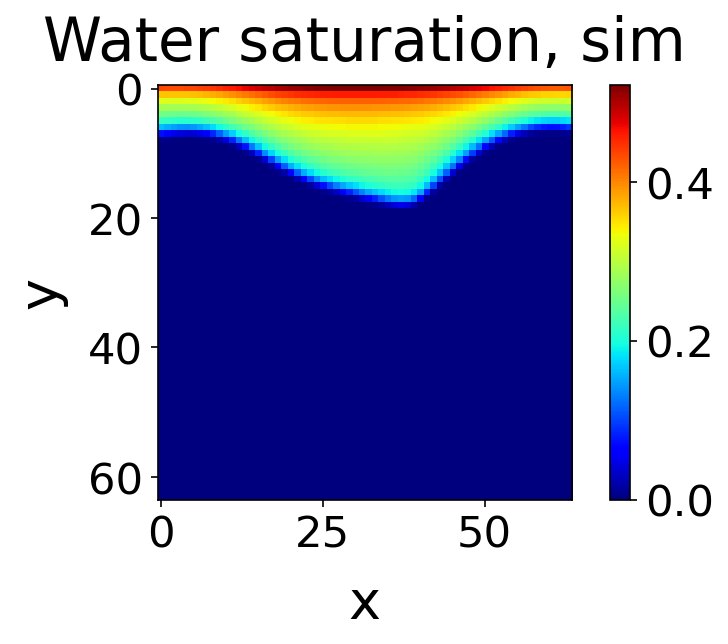

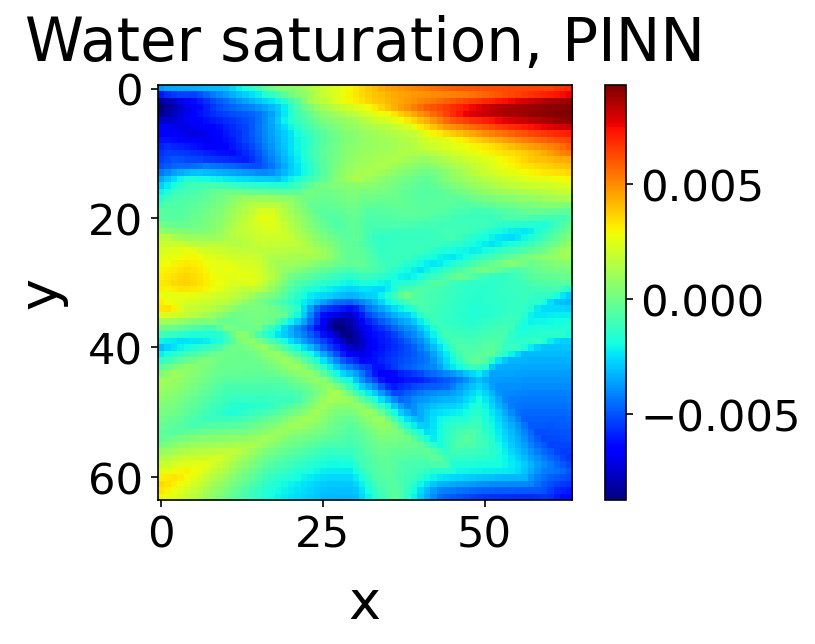

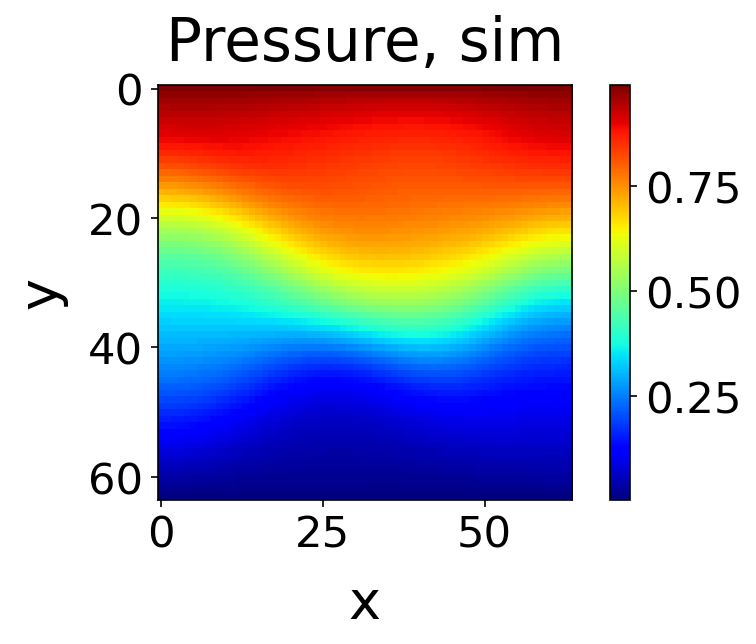

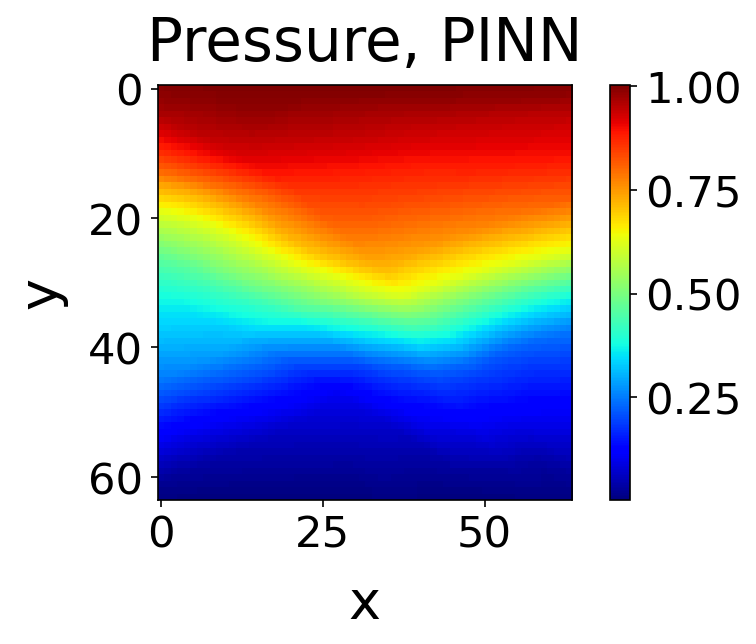

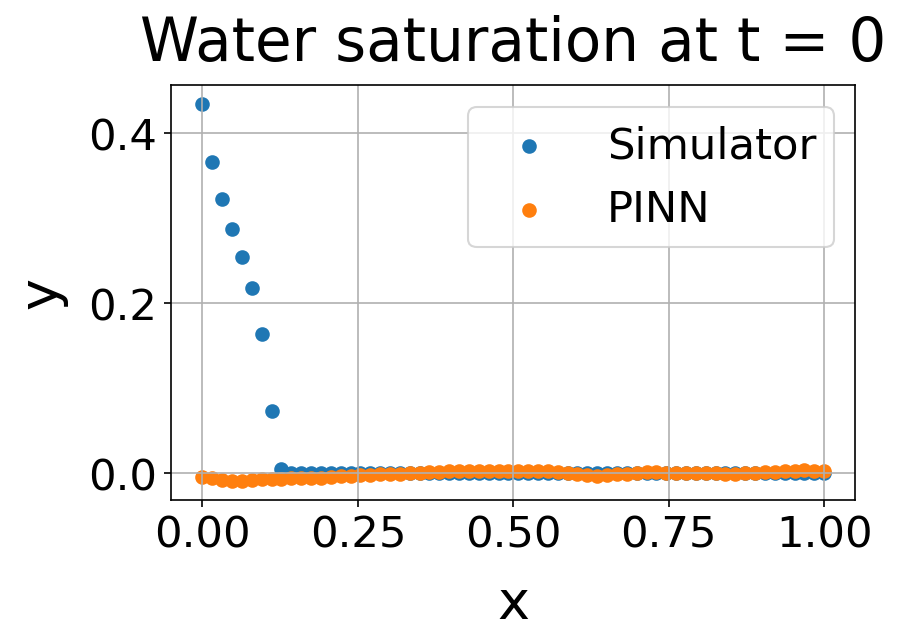

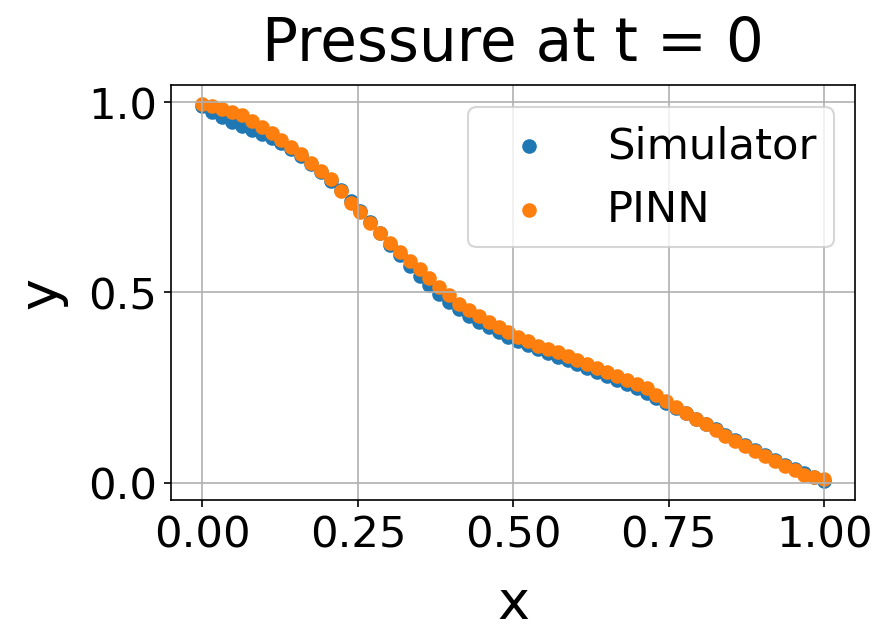

In [147]:
def set_big_plot_style(scale: float = 1.2):
    """Global matplotlib style for bigger text/ticks/legend and sharper saved figs."""
    base = 18 * scale
    title = 22 * scale
    label = 20 * scale
    ticks = 16 * scale
    legend = 16 * scale

    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,

        "font.size": base,
        "axes.titlesize": title,
        "axes.labelsize": label,
        "xtick.labelsize": ticks,
        "ytick.labelsize": ticks,
        "legend.fontsize": legend,

        "axes.titlepad": 12,
        "axes.labelpad": 10,
    })

def _add_colorbar_big(im):
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=plt.rcParams.get("ytick.labelsize", 16))
    return cbar

# def main_new(model):
set_big_plot_style(scale=1.3)
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

dt = 0.26e-1
niter = 100


# swat = np.zeros((nx0, nx1, nx2))
# soil = np.ones((nx0, nx1, nx2))


# pres, swat, soil = compute_solution(perm, poro,
#                                     dx0, dx1, dx2, dt * niter, niter,
#                                     pwat, kwat, poil, koil, vr,
#                                     pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * torch.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
model_prediction = model_prediction.detach().numpy()

swat_sim_2d = np.squeeze(swat[:, :, 0, -1])   # (nx0, nx1)
pres_sim_2d = np.squeeze(pres[:, :, 0, -1])   # (nx0, nx1)

swat_pinn_2d = np.squeeze(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, :, 0])
pres_pinn_2d = np.squeeze(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, :, 0])


plt.figure()
plt.title('Water saturation, sim')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('graphs/color_swat_sim.png', bbox_inches="tight")
plt.show()

plt.figure()
plt.title('Water saturation, PINN')
plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('graphs/color_swat_pinn.png', bbox_inches="tight")
plt.show()

plt.figure()
plt.title('Pressure, sim')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('graphs/color_pressure_sim.png', bbox_inches="tight")
plt.show()


plt.figure()
plt.title('Pressure, PINN')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('graphs/color_pressure_pinn.png', bbox_inches="tight")
plt.show()    


plt.figure()
plt.title('Water saturation at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.legend()
plt.savefig('graphs/swat_scatter.png', bbox_inches="tight")
plt.show()


plt.figure()
plt.title('Pressure at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.legend()
plt.savefig('graphs/pres_scatter.png', bbox_inches="tight")
plt.show()

    # return 0

In [58]:
# main_new(model)

# Metrics

In [59]:
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

dt = 0.26e-1
niter = 100


# swat = np.zeros((nx0, nx1, nx2))
# soil = np.ones((nx0, nx1, nx2))


# pres, swat, soil = compute_solution(perm, poro,
#                                     dx0, dx1, dx2, dt * niter, niter,
#                                     pwat, kwat, poil, koil, vr,
#                                     pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * torch.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
model_prediction = model_prediction.detach().numpy()

In [60]:
metrics = ['MSE', 'MAE', 'R_2', 'RMSE']

satur = [
    np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1])),
    r2_score(swat[:, 0, 0, -1], model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2))**0.5
]


press = [
    np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1])),
    r2_score(pres[:, 0, 0, -1], model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2))**0.5
]

In [61]:
data = pd.DataFrame({'Metrics': metrics,
                     'Saturation': satur,
                     'Pressure': press})

In [62]:
data

,Metrics,Saturation,Pressure
0,MSE,0.010434,0.001901
1,MAE,0.037081,0.032362
2,R_2,-0.143377,0.979213
3,RMSE,0.102145,0.043602
